## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г.   
(PJM Hourly Energy Consumption Data  https://www.kaggle.com/robikscube/hourly-energy-consumption).   
Содержит часовые измерения и после обработки добавлены метки по времени для календаря.

In [1]:
import os
import numpy as np
import pandas as pd 

from sklearn.metrics import mean_squared_error

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': (12,6)})
matplotlib.rcParams["axes.grid"] = True

In [4]:
# Загрузка файла
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.shape

(145374, 13)

In [5]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [6]:
# Переасчёт (ресемплинг) в представление по 1 месяцу
data_m = data.resample('M').mean()
data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


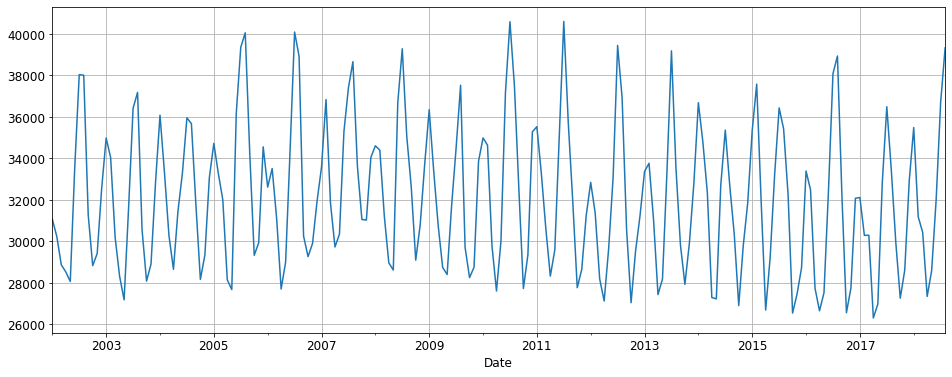

In [7]:
data_m.PJME_MW.plot(figsize=(16,6))

In [8]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('muted')

count      200.000000
mean     32108.628796
std       3534.668371
min      26314.458333
25%      29193.559812
50%      31879.175067
75%      34574.729839
max      40603.403226
Name: PJME_MW, dtype: float64

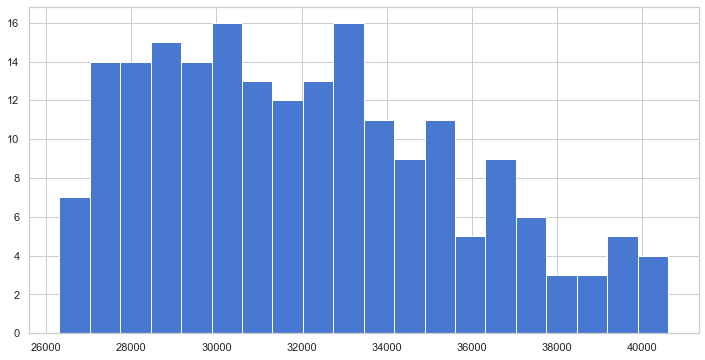

In [11]:
# Посмотрим на характеристики данного ряда
itog = data_m.PJME_MW.describe()
data_m.PJME_MW.hist(bins=20)
itog

In [12]:
print(f'V = {itog["std"]/itog["mean"]:.4f}')

V = 0.1101


Ряд у нас более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации:  
$V=σ/x$, где $σ$ - cреднеквадратическое отклонение, $x$ - среднее арифметическое выборки.

In [15]:
import statsmodels.api as sm

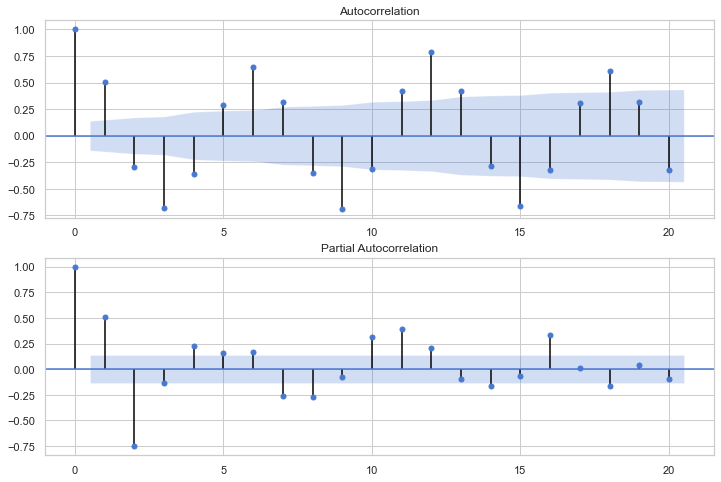

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_m.PJME_MW.values, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_m.PJME_MW.values, lags=20, ax=ax2)

Имеется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF)   
и для разностей важными являются значения внутри первых 3-х значений (PACF).   
Это позволяет определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца.

In [18]:
import warnings

# Определим p, d и q 
q = 3
p = 3
d = 1
pdq = [p, d, q]

# определим комбинации сезонных параметров p, q и q, 
# будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 2
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs, 12]

In [19]:
print('SARIMAX: p,d,q=', pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [3, 1, 3]    : ps,ds,qs, S= [1, 1, 2, 12]


In [20]:
# Для построения модели используем все данные, кроме 4-х последних месяцев (это будет тестовый набор)
# В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-4], order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[3, 1, 3]x[1, 1, 2, 12] - AIC:2745.3914321141337


In [21]:
print(results.summary().tables[0],results.summary().tables[1])

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  196
Model:             SARIMAX(3, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -1362.696
Date:                                 Sun, 12 Jul 2020   AIC                           2745.391
Time:                                         10:38:13   BIC                           2775.826
Sample:                                              0   HQIC                          2757.753
                                                 - 196                                         
Covariance Type:                                   opg                                         
=============================================================================================== ==============================================================================
                 coef    std err          z      P>|z|   

Анализ результатов по results:   
коэффициенты при элементах модели имеют большие значения   

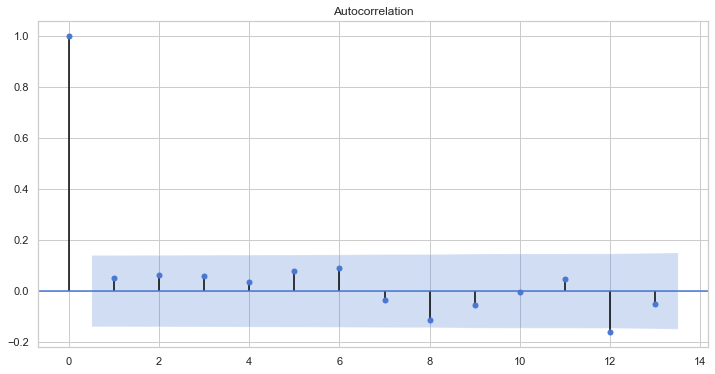

In [22]:
# Посмотрим на остатки ряда (results.resid) с точки зрения автокорреляции
# и убедимся, что они не имеют значительной корреляции
sm.graphics.tsa.plot_acf(results.resid, lags=13)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

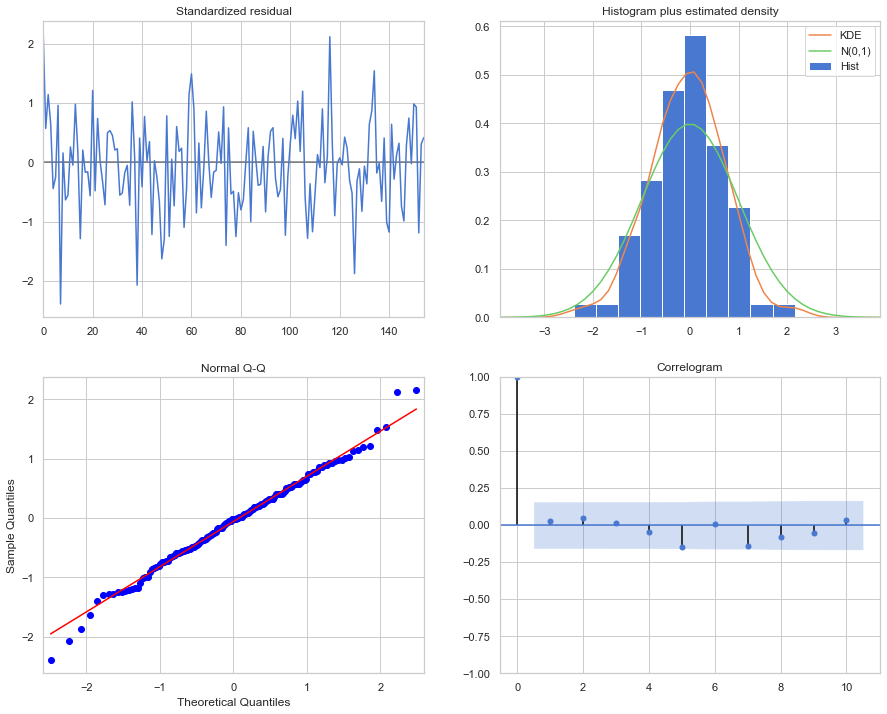

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор:

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда.
    
- задаем длину сезона: 12 месяцев
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [24]:
import itertools

# Определим p, d и q
d = [1] 
p = [3, 4]
q = [1, 2, 3]
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [1, 2, 3] 
d = [1]
q = [1, 2, 3]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (3, 1, 2) x (1, 1, 2, 12)
SARIMAX: (3, 1, 2) x (1, 1, 1, 12)
SARIMAX: (3, 1, 3) x (1, 1, 1, 12)
SARIMAX: (3, 1, 3) x (1, 1, 2, 12)


In [25]:
data_m['PJME_MW'].values.shape

(200,)

In [28]:
warnings.filterwarnings("ignore")
from tqdm import tqdm, tqdm_notebook

min_aic = 999999.0
for param in tqdm_notebook(pdq, desc='Param'):
    for param_seasonal in tqdm_notebook(seasonal_pdq, desc='Season-Param'):
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[0:-4],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            #print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                min_prm = param
                min_prs = param_seasonal
        except:
            continue

In [29]:
print(f'Лучшие результаты: param - {min_prm} param_seasonal - {min_prs} aic - {min_aic:.4f}')

Лучшие результаты: param - (4, 1, 1) param_seasonal - (3, 1, 1, 12) aic - 2508.2027


In [30]:
# Для построения модели используем все данные, кроме 4-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[0:-4], order=[4,1,1],
                                seasonal_order=[3,1,1,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2508.2026582104836


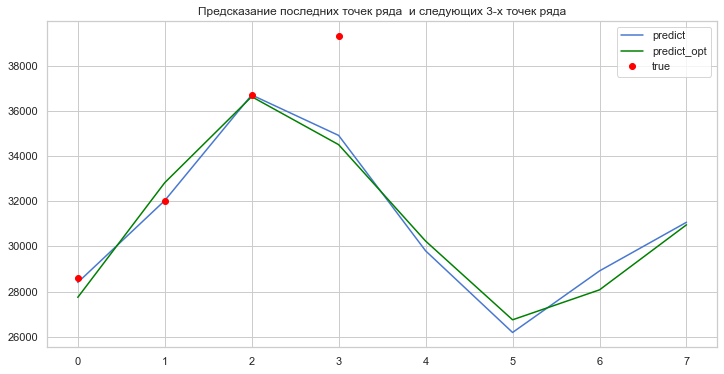

In [31]:
pred_dynamic = results.forecast(8)    # Делаем предсказание на 4 точки (месяца) от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(8)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-4:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 3-x точек ряда')
plt.legend()

plt.show()

Mодель, которую выбрали по сетке, в данном случае, не лучше обходит точки, известные нам заранее.   

In [32]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-5.032514527452113, 1.912934593236915e-05, 12, 183, {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}, 3188.639388966478)


Предсказания месячной модели имеют меньшую ошибку (оценку AIC) по сравнению с недельной.